# Path Signatures for Drone Identification using Esig
Jessica Toudic, Peter Foster, and Terry Lyons

This notebook demonstrates the use of **path signatures** for identifying drones similar to this one:

![title](img/256px-Quadcopter_camera_drone_in_flight.jpg)

More specifically, we will use the Python package [esig](https://esig.readthedocs.io/) to compute the path signatures of simulated radio waves reflected off the surface of drone and non-drone objects. Our mathematical model of a drone consists of a slowly moving body and a single, rapidly moving propeller. Relative to an observer who emits radio pulses and receives their reflections, owing to the [Doppler effect](https://en.wikipedia.org/wiki/Doppler_effect) we expect that the signal characteristics of radio pulses reflected off the drone's propeller differ from the signal characteristics of radio pulses reflected off the drone's body.

We will attempt to distinguish between drone and non-drone objects, where we assume that when we reflect radio pulses off drones, a proportion of those reflections are caused by the drone's body, with the remainder of reflections caused by the drone's propeller. Our non-drone model consists of a slowly moving body (identical to the one used in the drone), omitting the propeller present in the drone model.

The core mathematical object that we will use to construct our features is a sequence of iterated integrals, known as the path signature CITE. We compute path signatures up to a specified truncation level, which yields a low-dimensional representation of the $N$-dimensional path $X:[a, b]\to \mathbb{R}^N$. We will construct piecewise linear paths by aligning pairs of incident and reflected radio pulses in terms of their start and end times, then stacking their time series.

Subsequently, we will estimate **expected path signatures** by averaging path signatures obtained for several thousand simulated radio pulses reflected off random locations of drone objects. The approach of using expected path signatures aims at characterising the random behaviour of reflected signals. Taking expected path signature estimates as our feature vectors, we will consider the task of distinguishing between drone and non-drone objects, in addition to predicting the number of rotations per minute (RPM) of the drone's propeller.

In [7]:
# TODO Create Schematic of drone object, and non-drone object, including incident and reflected pulses.

# TODO Terminology: Don't use 'static object', rather use 'non-drone object'.
# TODO Terminology: Don't use 'system'
# TODO Terminology: 'Signal' versus 'Pulse' versus 'Wave'
# TODO Truncate to Order K

# Method

## Drone Model
We consider a low speed body roughly $30$cm in diameter. A rotating device placed on top of the drone represents a propeller with two blades. In this way, we model a drone as a two-component system, consisting of a body and a propeller.

Our incident signal is an electromagnetic sine wave comprising $1000$ wavelengths. The sine wave has frequency $\mathcal{f}=1$GHz, thus its wavelength is approximately $30$cm. When the incident signal hits either of the two moving objects, it produces a reflected signal. In practice, reflections may occur at a rate of $8$kHz, however for the purpose of this notebook we will consider a rate of $3$kHz.  An observer positioned at a fixed location emits the incident signals and observes the reflected signals.

We model the drone's body as a perfect mirror, located on a plane perpendicular to the observer and moving at constant speed relative to the observer. We assume a propeller with diameter $d$, and further assume that each individual point on the propeller is a tiny perfect mirror perpendicular to the observer and moving at constant velocity relative to the observer. The speed of the propeller acting as a mirror varies according to the distance along the propeller blade and further depends on the propeller's speed (measured in RPM), as well as the propeller's angle when the reflection occurs. We also assume that the entire signal hits the same 'tiny mirror'. That is, the mirror's speed and position remain constant for the duration of the reflection; the mirror does not change direction and thus does not accelerate. We assume that the observer generates $3000$ incident signals which consequently undergo reflection by either the drone's body or the propeller. These reflected signals are subsequently received back by the observer for analysis. We may interpret this setup as though the number of incident signals generated by the observer is greater or equal to 3000, however 3000 signals undergo reflection and are subsequently received by the observer.

We model the incident signal $\mathcal{E}_{i}(x,t)$ observable at location $x$ and time $t$ as a monochromatic plane wave moving in the positive x-direction away from the observer located at position $x_0=0$. The incident signal has angular frequency $\omega_i = 2\pi\mathcal{f}_i$, wavenumber $k = \frac{\omega_i}{c}$ and amplitude $A_i$,

$$\mathcal{E}_{i}(x,t) = A_{i} \hspace{0.05cm} sin(\omega_i t - kx)$$

where we use the subscript $i$ to denote that we are dealing with the incident signal.

The mirror trajectories $r(t)$ are given by

$$r(t) = vt + r_0$$

where $v$ is the speed of the mirror and where $r_0$ is the intial position of the mirror with respect to the observer. We assume $|v|\ll c$.

We compute $v$ and $r_0$ as follows: we assume that the centre of the two blades is the same distance $z$ from the observer as the drone's body. We denote with $\theta$ the anticlockwise angle between the the plane of the drone's body and propeller blade. We denote with $d$ the diameter of the propeller, and denote with $p$ the position along the blade where the incident signal is reflected. Furthermore, we denote with $R$ the propeller's speed in RPM. For the cases where $\theta=\frac{\pi}{2}$ or $\theta=\frac{3\pi}{2}$, we assume that then the signal has hit the end of the propeller blade, which has velocity zero with respect to the moving body. Denoting with $v_b$ the velocity of the moving body, we define

$$r_0 =
    \begin{cases}
        \text{$z-\frac{d}{2}$} &\quad\text{if $\theta=\frac{\pi}{2}$ or $\theta=\frac{3\pi}{4}$}\\
        \text{$p\,sin(\theta) + z$} &\quad\text{otherwise}\\
    \end{cases}$$

and 

$$v = 
    \begin{cases}
        \text{$v_b$} &\quad\text{if $\theta=\frac{\pi}{2}$ or $\theta=\frac{3\pi}{4}$}\\
        \text{$v_b + 2 \pi p\left(\frac{R}{60}\right)$} &\quad\text{otherwise.}\\
    \end{cases}$$
    
When the incident signal hits and reflects off an object moving at constant velocity, we observe a change in the the signal's frequency, which depends on the object's velocity and the signal's direction of propagation. This change in frequency is known as the Doppler effect CITE. According to [1], for the reflected signal $\mathcal{E}_{r}(x,t)$ we have

$$\mathcal{E}_{r}(x,t) = -\left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}}\right) A_{i} sin \left[ \left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}}\right) \left(\omega_i t + kx\right) - 2k\left(\frac{r_0 -vt_0}{1+\frac{v}{c}}\right) \right].$$

We denote with $s = \left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}} \right)$ the factor by which the frequency changes. If $v>0$ (the object is moving away from the observer), we have $s<1$, and thus the frequency decreases. If $v<0$ (the object is moving towards the observer), we have $s>1$, and thus the frequency increases. Using $\omega_r$, $A_r$, $T_r$ and $T_i$ to denote respectively the reflected signal's angular frequency, the reflected signal's amplitude, the reflected signal's wave period and the incident signal's wave period, we have:

$$ 
\omega_{r} = s \omega_{i}, \hspace{1cm} A_{r} = s A_{i}, \hspace{1cm} T_{r} =s^{-1} T_{i}.\\
$$

We emit our 3000 incident signals towards our drone model one at a time as separate pulses; to avoid interference a pulse is only emitted after the previously reflected one has returned to the observer. We specify that a proportion of our emitted 3000 pulses reflect off the drone's body, and the rest off the drone's propeller. We assume that the drone's body is far larger in volume than the drone's propeller, thus the majority of the reflections are caused by the drone's body. If we wished to increase the number of propellers in our model, this might be represented by increasing the proportion of signals reflecting off the propeller in our proposed model.

We will consider RPM values between 8000 and 12000. This implies that the propeller rotates a minimum of 50 times over the duration of emitting 3000 pulses, with approximately 60 pulses emitted per propeller rotation. Given the large number of signals emitted per rotation, we model event of a signal hitting the propeller as sampling a random angle $\theta \in [0, 2\pi)$ and a random position $p \in [0, d/2)$ along the blade.

## N-Dimensional Paths

An $N$-dimensional path is a mapping $X:[a, b]\rightarrow \mathbb{R}^N$ defined by $N$ piecewise smooth functions on the interval $[a, b]$. Equivalently, we may represent $X$ in terms of its real-valued coordinates $X(t)=(X_t^1, \ldots, X_t^N)$ parametrised by $t \in [a, b]$. In our case, we will construct a 3-dimensional path from each pair of incident and reflected signals.

Let us first consider the 2-dimensional path $Y: [a,b] \rightarrow \mathbb{R}^2$. Due to the Doppler effect, the time interval to complete 1000 wavelengths differs between incident and reflected signals. To ensure identical start and end times, we time-align the samples of incident and reflected signals.

We want both signals to start at amplitude $0$. So, we define $\mathcal{E}_{i}(0,t):[t_1, t_2] \rightarrow \mathbb{R}$ and $\mathcal{E}_{r}(0,t):[t_3, t_4] \rightarrow \mathbb{R}$, where $t_1, t_2, t_3$ and $t_4$ are such that

$$
    \omega_i t_1 - kx = 0; \hspace{1cm} t_2 = t_1 + 1000T_{i};\hspace{1cm} \left( \frac{1-\frac{v}{c}}{1+\frac{v}{c}}\right) \left(\omega_i t_3 + kx\right) - 2k\left(\frac{r_0 -vt_0}{1+\frac{v}{c}}\right) = 0;\hspace{1cm} t_4 = t_3 + 1000T_{r}.\\
$$

We generate $100\,000$ samples for each incident signal and reflected signal, respectively based on the intervals $[t_1, t_2)$ and $[t_3, t_4)$. This corresponds to a constant rate of $100$ samples per period. Since the signals have identical numbers of samples, defining $\tau_i(u) = (t_2-t_1)u + t_1$ and $\tau_r(u) = (t_4-t_3)u + t_3$ we can then create the 2-dimensional path $Y(u) = \left(\mathcal{E}_{i}(0, \tau_i(u)), \mathcal{E}_{r}(0, \tau_r(u))\right), u \in [0, 1)$ in a straightforward manner, on the basis of stacking their time series. Note that because our signals are sampled at finitely many times, we construct $Y$ by interpolating between a finite number of stream coordinates $\hat{Y}(t) = \left(\mathcal{E}_{i}(0, \tau_i(t)), \mathcal{E}_{r}(0, \tau_r(t))\right)$ which we observe at discrete times $u_1, \ldots, u_M$.

### The Lead-Lag Transformation

TODO-(avoid using index i for incident signal, it looks weird and clashes with the following)
TODO time indices clash also.

Instead of operating on the described 2-dimensional path $Y$ directly, we construct a path $X$ of dimensionality $N=3$ as follows: First, we define the lead-transformed stream $\hat{Y}(j)^{\text{lead}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{Y}(j)^{\text{lead}} =
    \begin{cases}
        \hat{Y}(u_i) \quad \text{if $j$ = 2i}\\
        \hat{Y}(u_i) \quad \text{if $j$ = 2i - 1}.
    \end{cases}
$$
Analogously, we define the lag-transformed stream $\hat{Y}(j)^{\text{lag}}$ observed at times $1, \ldots, 2M$ as
$$
\hat{Y}(j)^{\text{lag}} =
    \begin{cases}
        \hat{Y}(u_i) \quad \text{if $j$ = 2i}\\
        \hat{Y}(u_i) \quad \text{if $j$ = 2i + 1}.
    \end{cases}
$$
The lead-lag transformation $\hat{Y}^{\text{lead-lag}}$ of $\hat{Y}$ is the 4-dimensional stream that we obtain by stacking streams $\hat{Y}^{\text{lead}}$ and $\hat{Y}^{\text{lag}}$,
$$
\hat{Y}(j)^{\text{lead-lag}} = (\hat{Y}(j)^{\text{lead}}, \hat{Y}(j)^{\text{lag}}).
$$
The motivation for using the lead-lag transformation is that it may facilitate subsequent encoding of relevant information such as TODO using the path signature CITE. In practice, we consider the 3-dimensional *partial lead-lag transformation* $\hat{X}$, which we obtain by stacking onto $\hat{Y}^{\text{lead}}$ only those components in $\hat{Y}^{\text{lag}}$ whose TODO we seek to represent. In our case, we are interested in the characteristics of the reflected signal $\mathcal{E}_{r}$, thus we specify
$$
\hat{X}(j) = (\hat{Y}(j)^{\text{lead}}, \hat{Y}(j)_{\text{ref}}^{\text{lag}})
$$
where subscript $\text{ref}$ denotes that we only consider the component of interest, corresponding to the lag-transformed reflected signal.

It is important to emphasise that in terms of our implementation, the core object that we operate on is the 3-dimensional stream $\hat{X}$ that we obtain for each pair of incident and reflected signals. The path $X$ is the result of interpolating between stream coordinates in $\hat{X}$.

## Path Signatures

We wish to characterise our drone model using the **signature** of the path $X:[a,b]\rightarrow \mathbb{R}^N$, where we obtain a path $X$ for each of our 3000 pairs of incident and reflected signals.

From an informal perspective, the signature $S(X)$ is the infinite ordered set of real-valued terms
\begin{align}
S(X) &= (1, S^1, S^2, \ldots,  S^N,\\
     &\quad \quad S^{1, 1}, S^{1, 2}, \ldots, S^{N, N},\\
     &\quad \quad S^{1, 1, 1}, S^{1, 1, 2}, \ldots, S^{N, N, N},\\
     &\quad \quad \ldots)
\end{align}
with term $S^{(i_1,...,i_k)}$ at index $(i_1,...,i_k)$ defined as the $k$-fold iterated path integral
\begin{equation}
S^{(i_1,...,i_k)} = \int\limits_{a < r_k < b} \ldots \int\limits_{a < r_1 < r_2} \,dX^{i_1}_{r_1} \ldots \,dX^{i_k}_{r_k}.
\end{equation}

The signature $S(X)$ is known to determine $X$ uniquely $[3]$ TODO-(really/under what conditions)?.

Due to computational constraints, we cannot compute the entire path signature. Therefore, in practice we truncate the signature to order $K \geq k$, thus obtaining $\sum_{k=0}^{k=K} N^{k}$ terms. For example, if we truncate to order $K=2$, the signature of a 2-dimensional path consists of the terms

$$ S(X) =\big( 1 ,  S^{(1)}(X) , S^{(2)}(X) , S^{(1,1)}(X), S^{(1,2)}(X), S^{(2,1)}(X), S^{(2,2)}(X) \big).$$

From now on, when we refer to path signatures we will mean the truncated path signatures.

Note that if we set $K$ too small, we may discard important information characterising our drone model. Conversely, if we set $K$ too large, we may end up including redundant information TODO-(Why). In addition, we must take care that our higher-order terms are not affected by numerical precision issues: Note for example that if we scale a 2-dimensional path by the factor 2, the $n$th term of its signature scales by the factor $2^n$. Hence we must find a suitable truncation level for our path signatures. TODO change examples to 3-dimensional paths?

## Expected Path Signatures

A stochastic process is uniquely characterised by its expected signature $[4]$. We will think of the reflections of waves off our drone model as samples from stochastic process. We seek to uniquely characterise our system by estimating its expectated signature as the empirical mean of the 3000 individual signatures that we obtain from our incident/reflected signal pairs. We consider the expected signature $E(S)$ truncated to order $K$, whose terms we will denote as $(\bar{S}_0, \bar{S}_1, ... \bar{S}_r)$, where $r = \sum_{k=0}^{k=K} N^{k}$. TODO-(isn't this notation confusing, when we have the index notation for coefficients?)

# Code for Estimating the Expected Path Signature

We use [Esig](https://esig.readthedocs.io/en/latest/) to compute path signatures from our incident and reflected signals. We first install required package dependencies, including Esig:

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

Import required packages:

In [1]:
import itertools

from expected_path_signatures import ExpectedSignatureCalculator

import esig.tosig
import joblib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import scipy
import sklearn
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline
import sklearn.preprocessing
import tqdm.notebook

We seek to estimate the expected signature of our proposed drone model, based on incident and reflected signals that we generate as described above.

TODO Needs updating
To this end, we implement a class *ExpectedSignatureCalculator()* for calculating the expected signature of our system. Class members specify various constants and the method *compute_for_system()* executes the process described above.

Our class *ExpectedSignatureCalculator()* furthermore defines a method *compute_for_nonrotating_object()*. We will use this method to evaluate our ability to distinguish our drone model from a model of an entirely non-rotating object.

To enable faster execution times on multi-processor systems, we utilise Joblib to compute path signatures in parallel. For additional convenience, using the function *cache_result()* we save results that we compute to a pickle file. Subsequently, we compute only those results that do not already exist in this 'cache' pickle file.

In [2]:
def parallel_grid_search(function_to_execute, description, *parameter_ranges):
    parameter_space = list(itertools.product(*parameter_ranges))
    random_states = np.random.randint(np.iinfo(np.int32).max, size=len(parameter_space))
    
    results = joblib.Parallel(n_jobs=multiprocessing.cpu_count(), backend='loky')(
        joblib.delayed(function_to_execute)(*parameter_combination, random_state)
        for parameter_combination, random_state in tqdm.notebook.tqdm(list(zip(parameter_space, random_states)),
                                                                      desc=description))
    
    return np.array(results)

# Classification Problem: Drone vs. Non-Drone

We now seek to use the expected signature to classify objects as 'drones' vs. other non-drone objects.

We estimate expected path signatures for 'drone' and 'non-drone' models, where we consider object speeds in the range $[0, 40]$ and object distances in the range $[50, 1000]$. 

We achieve this by performing a logistic regression on a set of expected signatures from both the 'drone' and a non-drone object. To this end, we use our method *compute_for_nonrotating_object()* for calculating the signature of a non-drone object.

We must then create a data set of signatures from this non-drone object, and a data set of expected signatures from our 'drone'. We consider many different configurations of our 'drone', characterised by a collection of hyperparameters. For this, we must define the ranges of hyperparameters we wish to use. The ranges chosen are arbritrary, and the regression may be performed for other ranges of your choice.

In [ ]:
np.random.seed(0)

signature_calculator = ExpectedSignatureCalculator(n_incident_signals=3000, truncation_level=3,
                                                   use_lead_lag_transformation=True, signal_to_noise_ratio=101)
rpms=[12000,]
speeds=np.arange(0, 41, 2)
diameters=[0.08,]
distances=np.arange(50, 1001, 200)
proportions=[0.8,]

def get_drone_signatures_across_parameters(signature_calculator, rpms, speeds, diameters, distances, proportions,
                                           description='Drone signatures'):
    return parallel_grid_search(signature_calculator.compute_expected_signature_for_drone, description,
                                rpms, speeds, diameters, distances, proportions)

def get_nondrone_signatures_across_parameters(signature_calculator, speeds, distances,
                                              description='Non-drone signatures'):
    return parallel_grid_search(signature_calculator.compute_expected_signature_for_nondrone, description,
                                speeds, distances)

drone_signatures = get_drone_signatures_across_parameters(signature_calculator, rpms, speeds, diameters, distances,
                                                          proportions)
nondrone_signatures = get_nondrone_signatures_across_parameters(signature_calculator, speeds, distances)

# TODO we disregard the 0th / 1st coefficient in our subsequent analysis
X = np.vstack((drone_signatures[:, 1:], nondrone_signatures[:, 1:]))
Y = np.append(np.ones(len(drone_signatures)), np.zeros(len(nondrone_signatures)))
feature_names = esig.tosig.sigkeys(3, signature_calculator.truncation_level).split(' ')[2:]

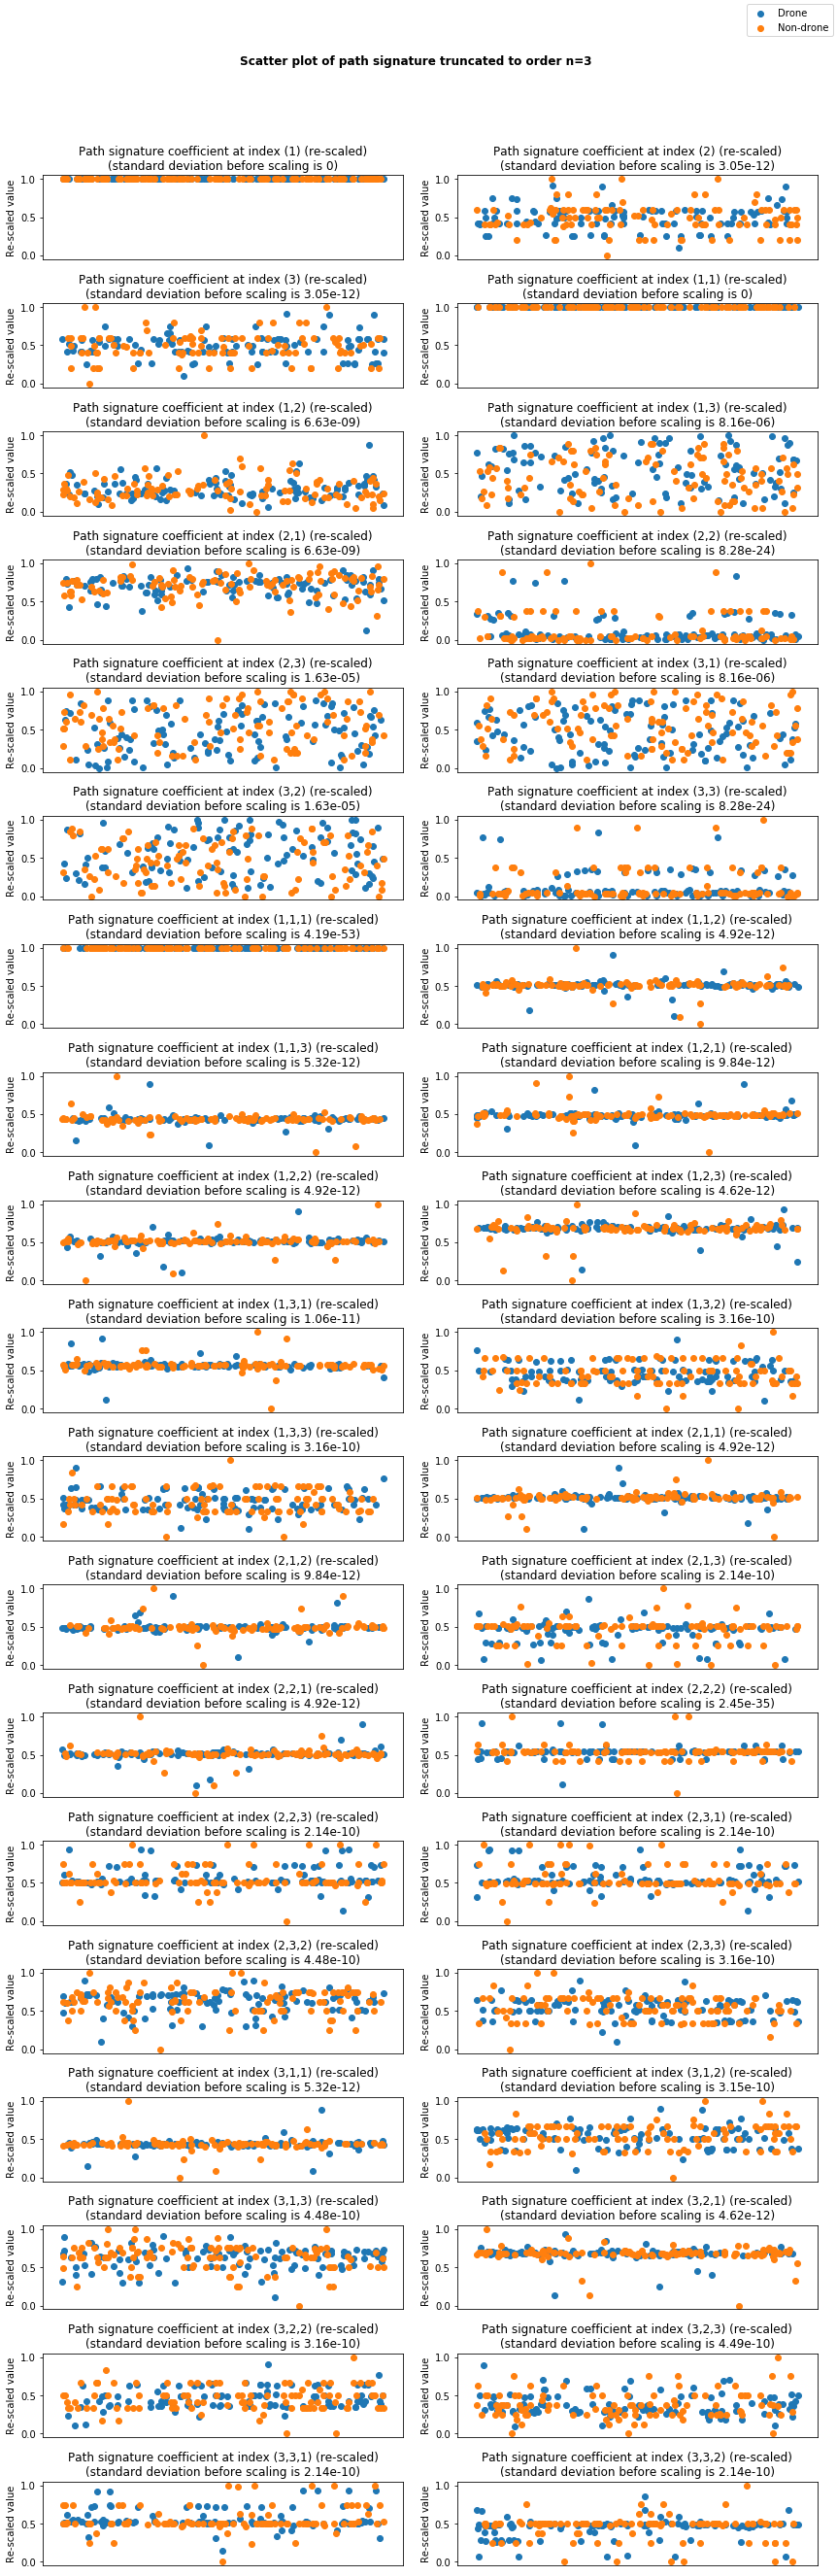

In [4]:
# TODO Should we remove global parameters?
def plot_feature(X, Y, feature_index, ax, features=feature_names):
    X_rescaled = X[:, feature_index] - np.min(X[:, feature_index]) + np.spacing(0)
    X_rescaled = X_rescaled / np.max(X_rescaled)
    X_grouped = {cls: X_rescaled[Y==cls] for cls in (True, False)}
    for cls in (True, False):
        ax.scatter(np.random.uniform(size=len(X_grouped[cls])), X_grouped[cls])

    ax.set_ylim([-0.05, 1.05])
    ax.set_xticks([])
    ax.set_ylabel('Re-scaled value')
    ax.set_title('Path signature coefficient at index {} (re-scaled)'
                 '\n(standard deviation before scaling is {:.3g})'.format(features[feature_index],
                                                                          np.std(X[:, feature_index], ddof=1)))

fig, axs = plt.subplots(X.shape[1] // 2, 2, figsize=(12, (X.shape[1] // 2) * 2.0), sharey=False)
fig.suptitle('Scatter plot of path signature truncated to order n={}'.format(signature_calculator.truncation_level),
             fontweight='bold', verticalalignment='top')

for feature_index, ax in enumerate(np.ravel(axs)):
    plot_feature(X, Y, feature_index, ax)
    
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.legend(labels=('Drone', 'Non-drone'), loc='upper right')
plt.show()

Next, we fit a logistic regression model. We first evaluate the effect of the regularisation parameter on training and testing data performance, quantifying performance in terms of cross entropy. With respect to testing data performance, using the optimal regularisation parameter value, we then compute a receiver operating characterisic (ROC) curve.

In [6]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.33, random_state=0)

regularisation_strengths = np.logspace(-20, 20, 100)
penalty = 'l2'
model = sklearn.linear_model.LogisticRegression(penalty=penalty, random_state=0, solver='liblinear')
pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), model)

train_results = []
test_results = []
for reg_strength in regularisation_strengths:
    model.set_params(C=1/reg_strength)
    pipeline.fit(X_train, Y_train)
    train_results.append(sklearn.metrics.log_loss(Y_train, pipeline.predict_proba(X_train)))
    test_results.append(sklearn.metrics.log_loss(Y_test, pipeline.predict_proba(X_test)))
    
i_optim = np.argmin(test_results)
regularisation_strength_optim = regularisation_strengths[i_optim]

# Estimate final model using optimal regularisation parameter value
model.set_params(C=1/regularisation_strength_optim)
pipeline.fit(X_train, Y_train)

final_results = {}
final_results['accuracy'] = pipeline.score(X_test, Y_test)
final_results['fpr'], final_results['tpr'], _ = sklearn.metrics.roc_curve(Y_test,
                                                                          pipeline.predict_proba(X_test)[:, 1])
final_results['auc'] = sklearn.metrics.auc(final_results['fpr'], final_results['tpr'])

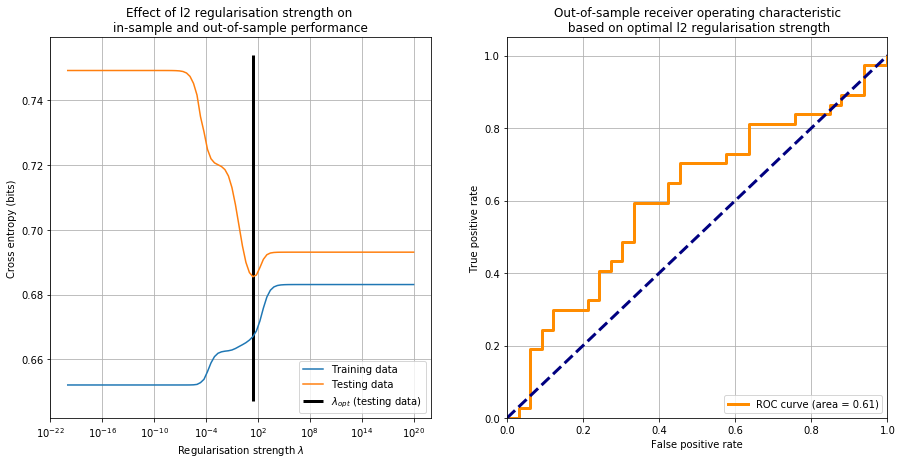

In [7]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.semilogx(regularisation_strengths, np.array(train_results) - 0.01, label='Training data')
plt.semilogx(regularisation_strengths, np.array(test_results), label='Testing data')
plt.vlines(regularisation_strength_optim, plt.ylim()[0], plt.ylim()[1], color='k',
           linewidth=3, label='$\lambda_{opt}$ (testing data)')
plt.legend(loc='lower right')
plt.xlabel('Regularisation strength $\lambda$')
plt.ylabel('Cross entropy (bits)')
plt.title('Effect of {} regularisation strength on \nin-sample and out-of-sample performance'.format(penalty))
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(final_results['fpr'], final_results['tpr'], color='darkorange',
         linewidth=3, label='ROC curve (area under curve= %0.2f)' % final_results['auc'])
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', linewidth=3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Out-of-sample receiver operating characteristic\n based on optimal {} regularisation strength'.format(penalty))
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Regression Problem: Predicting the Propeller RPM Value

We wish to use the expected signature to predict the RPM of our system. We want to construct a function $h$ that takes the expected signature of our system as an input, and outputs the RPM.

$$h\big( E(S) \big) = R$$

By the Stone-Weierstrass Theorem, we may approximate $h$ by $\tilde{h}$, a linear combination of terms of the expected signature of our system. We have, for coefficients $a_0, a_1, ..., a_r$,

$$\tilde{h}\big(E(S)\big) = a_0 + a_1S_1 \hspace{0.2cm} + ... + \hspace{0.2cm} a_rS_r.$$

To achieve this, we perform a linear regression using SciKit-Learn.

In [115]:
# TODO Why may we approximate the RPM using a linear combination of the expected signature?

TODO Variable K already taken. Check other variables.

To train the regression, we need a collection $\big\{(E(S)_k, R_k)\big\}_{k=1}^{k=K}$ of $K$ expected signatures and their RPMs. After training, we can then predict the RPM of a propeller in a system from its expected signature. We will test the regression with the same expected signatures that we trained it with, and then a new collection $\big\{\tilde{E}(S)_k, \tilde{R}_k)\big\}_{k=1}^{k=\tilde{K}}$ of $\tilde{K}$ expected signatures.

We want to determine the goodness of fit of the regression predictions. For this, we use the regression to predict RPMs for a collection of expected signatures. We then compute the coefficient of determination, the $R^2$ statistic, of the real RPMs against predicted. The $R^2$ score quantifies the goodness of fit: a score of 1 indicates that the regression perfectly approximates the real RPM, and a score of 0 the opposite. We will plot residual plots (actual against predicted RPMs) to show visually the goodness of fit.

We first need to determine the best truncation level (denoted $l$) for our signatures. For this, we pick fixed parameters for our function and perform a linear regression on a range of truncation levels. We choose (speed, d, z, number, proportion)=(20, 0.08, 100, 3000, 0.8) and RPMs from 8000 to 12000 in steps of 500. To begin, we choose to test the regression with the same expected signatures we trained it with.

In [6]:
np.random.seed(1)

# TODO increase to 3000
# TODO Why does this perform better than classification task?
signature_calculator = ExpectedSignatureCalculator(n_incident_signals=300, truncation_level=3,
                                                   use_lead_lag_transformation=True, signal_to_noise_ratio=100)

rpms_train=np.arange(8000, 14001, 100)
rpms_test=np.arange(8050, 14051, 100)
speeds=[20,]
diameters=[0.08,]
distances=[400,]
proportions=[0.8,]

drone_signatures_train = get_drone_signatures_across_parameters(signature_calculator, rpms_train, speeds, diameters,
                                                                distances, proportions,
                                                                description='Signatures at training RPMS')
drone_signatures_test = get_drone_signatures_across_parameters(signature_calculator, rpms_test, speeds, diameters,
                                                               distances, proportions,
                                                               description='Signatures at testing RPMS')

X = drone_signatures_train[:, 1:]
# TODO note about scaling
X = X - np.min(X, axis=0) + np.spacing(0)
X = X / np.max(X, axis=0)
Y = rpms_train
feature_names = esig.tosig.sigkeys(3, signature_calculator.truncation_level).split(' ')[2:]

/Users/pfoster/opt/anaconda3/envs/roughpaths_initial_project2/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


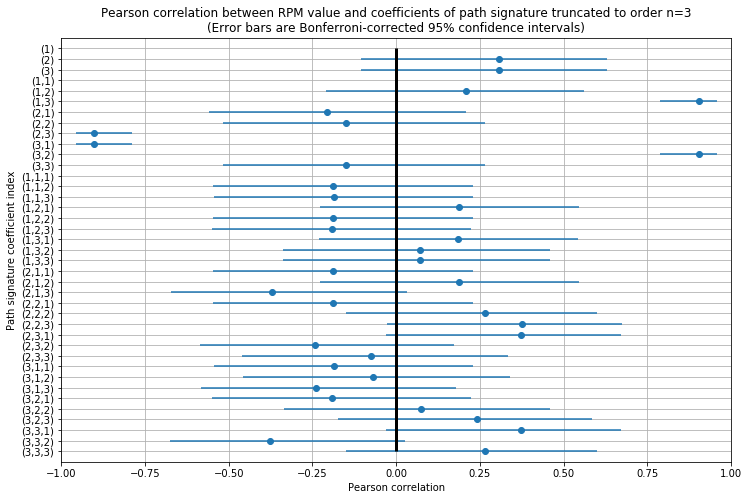

In [7]:
def r_to_z(r):
    # Convert r to z'
    return np.log((1 + r) / (1 - r)) / 2.0

def z_to_r(z):
    # Convert z' to r
    e = np.exp(2 * z)
    return((e - 1) / (e + 1))

def pearson_r_confidence_interval(r, n, alpha=0.95):
    # See http://onlinestatbook.com/2/estimation/correlation_ci.html
    # See https://stackoverflow.com/q/33176049
    
    z = r_to_z(r)
    se = 1.0 / np.sqrt(n - 3)
    z_crit = scipy.stats.norm.ppf((1 + alpha) / 2)  # 2-tailed z critical value

    lo = z - z_crit * se
    hi = z + z_crit * se

    return np.array((r - z_to_r(lo), z_to_r(hi) - r))

def plot_correlations(X, Y, feature_names):
    correlations = np.array([scipy.stats.pearsonr(X[:, i], Y)[0] for i in range(X.shape[1])])
    # Bonferroni-corrected confidence intervals
    confidence_intervals = pearson_r_confidence_interval(correlations, len(Y), 1-0.05/len(feature_names))
    
    plt.figure(figsize=(12, 0.2 * len(feature_names)))

    y = np.arange(len(correlations))
    plt.errorbar(correlations, y, xerr=confidence_intervals, fmt='o')
    plt.vlines(0, min(y), max(y), color='k', linewidth=3)

    plt.yticks(y, feature_names)
    plt.xlabel('Pearson correlation')
    plt.ylabel('Path signature coefficient index')
    plt.gca().invert_yaxis()
    plt.xlim([-1, 1])
    plt.ylim([len(correlations), -1])
    plt.title('Pearson correlation between RPM value and coefficients of path signature truncated to order n={}\n'
              '(Error bars are Bonferroni-corrected 95% confidence intervals)'.format(signature_calculator.truncation_level))
    plt.grid(True)
    plt.show()
    
plot_correlations(X, Y, feature_names)

In [8]:
regularisation_strengths = np.logspace(-10, 10, 100) # TODO Correct range
penalty = 'l2'
model = sklearn.linear_model.Ridge(fit_intercept=True, random_state=0)
pipeline = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), model)

train_results = []
test_results = []
final_results = []

for reg_strength in regularisation_strengths:
    model.set_params(alpha=reg_strength)
    pipeline.fit(drone_signatures_train, rpms_train)
    train_results.append(sklearn.metrics.r2_score(rpms_train, pipeline.predict(drone_signatures_train)))
    test_results.append(sklearn.metrics.r2_score(rpms_test, pipeline.predict(drone_signatures_test)))
        
i_optim = np.argmax(test_results)
regularisation_strength_optim = regularisation_strengths[i_optim]
    
# Estimate final model using optimal regularisation parameter value
model.set_params(alpha=regularisation_strength_optim)
pipeline.fit(drone_signatures_train, rpms_train)

final_results = {}
final_results['r2'] = sklearn.metrics.r2_score(rpms_test, pipeline.predict(drone_signatures_test))
final_results['predictions'] = pipeline.predict(drone_signatures_test)

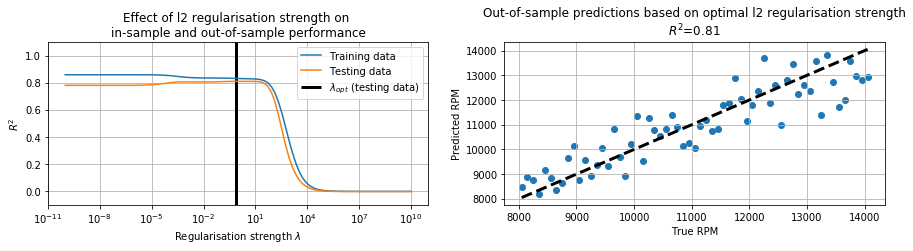

In [9]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title('Effect of {} regularisation strength on \nin-sample and out-of-sample performance'.format(penalty))
plt.semilogx(regularisation_strengths, train_results, label='Training data')
plt.semilogx(regularisation_strengths, test_results, label='Testing data')
plt.ylim([-0.1, 1.1])
plt.vlines(regularisation_strength_optim, plt.ylim()[0], plt.ylim()[1], color='k',
             linewidth=3, label='$\lambda_{opt}$ (testing data)')
plt.legend(loc='upper right')
plt.xlabel('Regularisation strength $\lambda$')
plt.ylabel('$R^2$')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Out-of-sample predictions based on optimal {} regularisation strength\n'
          '$R^2$={:.2}'.format(penalty, final_results['r2']))
plt.scatter(rpms_test, final_results['predictions'], color='darkorange')
plt.plot([min(rpms_test), max(rpms_test)], [min(rpms_test), max(rpms_test)],
           color='k', linestyle='--', linewidth=3)
plt.xlabel('True RPM')
plt.ylabel('Predicted RPM')
plt.grid(True)
plt.show()

In [13]:
model.coef_ / np.sum(model.coef_)

array([ 0.        ,  0.        ,  0.7278016 ,  0.7278016 ,  0.        ,
       -2.12364525,  7.24638318,  2.12364525,  0.66348869, -7.24774059,
       -7.24638318,  7.24774059,  0.66348869,  0.        ,  2.64294195,
       -3.98951036, -2.64294196,  2.59827257, -1.67374174,  3.98952684,
        0.05660919, -0.22860752,  2.64294196, -2.59827294, -0.72473496,
        2.59827332,  0.06350354,  0.83043325,  0.75532489, -0.50686287,
       -0.10814197, -3.98954331, -0.02902017, -0.08955441, -1.67367487,
        0.12388247,  0.48823102,  0.431243  , -0.81266105,  0.06350354])

# Conclusion
TODO

## References

$[1]$ Cooper. J, "Scattering of electromagnetic fields by a moving boundary - The one-dimensional case", $\textit{IEEE Transactions on Antennas and Propagation}$, vol. AP-28, Nov. 1980, p. 791-795.

$[2]$ Rahkmanov. M, "Reflection of light from a moving mirror: derivation of the relativistic Doppler formula without Lorentz transformations", 	arXiv:physics/0605100 [physics.ed-ph]

$[3]$ B.M. Hambly and Terry Lyons, "Uniqueness for the signature of a path of bounded variation and the reduced path group.", $\textit{Annals of Mathematics}$, 171(1):109–167, 2010.

$[4]$ Ilya Chevyrev and Terry Lyons, "Characteristic functions of measures on geometric rough paths.", Annals of Probability, Volume 44, Number 6 (2016), 4049-4082

$[5]$ Ilya Chevyrev and Andre Kormilitzin, "A Primer on the Signature Method in Machine Learning.", arXiv:1603.03788 [stat.ML]

$[6]$ Daniel Levin, Terry Lyons, Hao Ni, "Learning from the past, predicting the statistics for the future, learning an evolving system", 	arXiv:1309.0260 [q-fin.ST]
